In [1]:
import tweepy
import webbrowser
import time
import pandas as pd

# **1. Autenticación en Tweepy**

Para poder **acceder a la API**, se necesesita ingresar a la pagina de developer de twitter y solicitar el acceso, se te pedira contestar unas preguntas para autorizarte, una vez autorizado podras crear un projecto y te daran las consumer_key y consumer_secret


In [36]:
# Ingresar las llaves del proyecto
consumer_key = "428LGAjvxjIt4PheQS5uolCjH"
consumer_secret = "a4YXXbK6RtOqSe89ZtgCAZYy60NfQukJVSY3Y5V4nHepmPaKhR"

# Implementamos la PIN-based authorization
callback_uri = 'oob'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)
webbrowser.open(redirect_url)

# Se abre la apgina y autorizamos ingresando el PIN
user_pint_input = input("What's the pin value? ")
auth.get_access_token(user_pint_input)

https://api.twitter.com/oauth/authorize?oauth_token=6t66zwAAAAABG0rwAAABdB4oIgQ
What's the pin value? 7729004


('142591682-3Baypva2WtB5fflEh8w0UDw2Nuzcc7G4qlI150Nv',
 'xHU0l4rlksSqev3sgK9sTnwRg3TeNulT69O4Zpd2cI5uo')

In [37]:
# Verificamos imprimiendo nuesto nombre de usuario
api = tweepy.API(auth, wait_on_rate_limit=True)
me = api.me()
print(me.screen_name)

DanielOyama


# **2. Creamos una función para extraer los tweets dependiendo el hashtag**

Se recomienda revisar la documentación para ver toda la amplia informacón que se peude extraer de la API https://developer.twitter.com/en/docs

In [74]:
# Quitamos los retweets
# Seleccionamos a través de hashtags

def extract_tweets(hashtag, count):
  tweets = []
  for tweet in tweepy.Cursor(api.search, q=hashtag, lang='es', include_rts=False).items(count):
    if (not tweet.retweeted and 'RT @' not in tweet.text):
      tweets.append(tweet.text)
      # Se puede extraer mas informción (avatar, locaizacion, verificada, hashtag, user_name, user_id, tweets.entities(url, imagenes, source etc) 
  return tweets


# **3. Extracción de la data**

In [39]:
# Permitir acceso a drive para manipulación de archivos (Opcinal)
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
# Ingresar Hashtag que se deseamos y como lo queremos guardar
hashtag = '#Apple'
file_name = 'tweets'

In [75]:
# Ejecutamos la función para extraer los tweets
tweets = extract_tweets(hashtag, 200)

In [76]:
# Creamos el dataframe
df = pd.DataFrame(data=tweets, columns=['text'])

# Guardamos en google drive
path = f'drive/My Drive/Colab Notebooks/Tweepy/{file_name}.csv'
df.to_csv(path, sep=',', index=False)

In [6]:
# Verificamos que se hayan bajado los archivos
path = f'drive/My Drive/Colab Notebooks/Tweepy/{file_name}.csv'
df = pd.read_csv(path)
df.head(10)

,text
0,No te pierdas el Episodio 47 de Tu Podcast Cha...
1,#Finanzas | #Apple retiró los títulos de #Epic...
2,Amigos de @LaCondesa_ el lunes tenemos oferta ...
3,Contamos con la más alta tecnología para la re...
4,🎮📼😯 #Las3Claves de fin de semana: #Microsoft a...
5,#eldato #Argentina vale un cuarto de lo q vale...
6,#Macworld 2001 #SF #PowerBookG4 #Titanium Intr...
7,Apple retrasa lanzamiento del iPhone 12 y conf...
8,Invito a todos a visitar mi canal de YouTube e...
9,#EstaSemanaEnPSN La empresa estadounidense App...


# **3. Trasformamos el dataframe con tecnicas de NLP**

In [3]:
import nltk
import re
import string
from nltk .corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Creamos la funcion 'transform' que va a remover stopwords y algunos caracteres peculiares de twitter
# Tmabien 

def transform(text):
  stopWords = set(stopwords.words('spanish'))
  text = str(text)
  text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #Remover menciones @
  text = re.sub(r'RT[|\s]', ' ', text) # Remover RTs
  text = re.sub(r'#', ' ', text) #Remover # en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links

  pattern = r'''(?x)                    # set flag to allow verbose regexps
              (?:[A-Z]\.)+            # abbreviations, e.g. U.S.A
              | \w+(?:-\w+)*          # Words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?    # Currency and precentages, e.g. $12.40 82%
              | \.\.\.                # Ellipsis
              | [][.,;"'?():-_`]      #These are separate tokens; includes ],[
              '''
  words = nltk.regexp_tokenize(text, pattern)
  re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # Remover signos de puntuacion
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if  w.lower() not in stopWords] # Remover stopwords

  return (" ".join(no_garbage))

In [13]:
# Del listado de tweets le aplicamos la funcion transform para que nos quede un texto mas limpio
df['tweets_transform'] = df['text'].apply(transform)
df

,text,tweets_transform
0,No te pierdas el Episodio 47 de Tu Podcast Cha...,pierdas Episodio 47 Podcast Charlas iOS Dispo...
1,#Finanzas | #Apple retiró los títulos de #Epic...,Finanzas Apple retiró títulos EpicGames App St...
2,Amigos de @LaCondesa_ el lunes tenemos oferta ...,Amigos lunes oferta Apple tiempo actualizar
3,Contamos con la más alta tecnología para la re...,Contamos alta tecnología reparación equipos T...
4,🎮📼😯 #Las3Claves de fin de semana: #Microsoft a...,Las3Claves fin semana Microsoft apoya Epic Ga...
...,...,...
100,Trabajar en el propio iPad como pantalla princ...,Trabajar propio iPad pantalla principal usar p...
101,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...
102,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...
103,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...


# **4. Graficamos una Word Cloud**
Esta grafica nos sirve para ver de forma rapida las palabras mas usadas con el hashtag que escogimos

In [97]:
# Vamos a crear una WordCloud para verque palabras se repiten mas

from wordcloud import WordCloud

text = df.tweets_transform
text = " ". join(df.tweets_transform)
wordcloud = WordCloud(width=1024, height=800, background_color='white', min_font_size=14).generate(text)

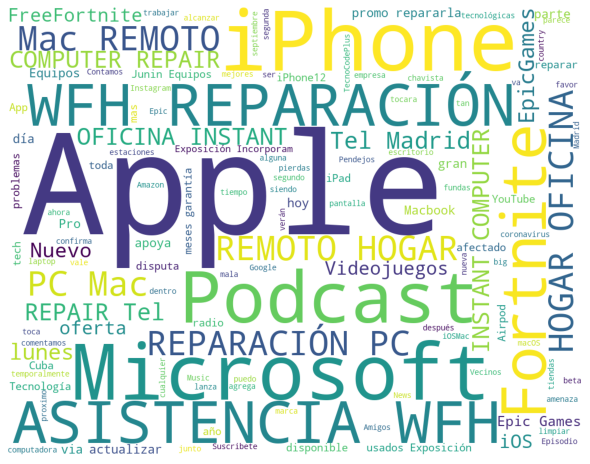

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# **5. Analisis de sentimiento de los tweets extraidos**

Con ayuda de la libreria TextBlob realizaremos el analisis de sentimiento de los tweets extraidos

In [14]:
# Creamos la funcion de analisis de sentimiento polaridad
from textblob import TextBlob
def set_Sentiment(text):
  text = str(text)
  if text != '':
    analysis = TextBlob(text)
    if analysis.detect_language() == 'es': 
      analysis = analysis.translate(from_lang='es', to='en').sentiment
      sentiment = analysis.polarity
      return sentiment

In [15]:
#Los rangos de va de -1 a 0 mas negativo, 0 neutrla y 0 a 1 positivo
df['polarity'] = df['tweets_transform'].apply(set_Sentiment)
df

,text,tweets_transform,polarity
0,No te pierdas el Episodio 47 de Tu Podcast Cha...,pierdas Episodio 47 Podcast Charlas iOS Dispo...,0.45
1,#Finanzas | #Apple retiró los títulos de #Epic...,Finanzas Apple retiró títulos EpicGames App St...,-0.40
2,Amigos de @LaCondesa_ el lunes tenemos oferta ...,Amigos lunes oferta Apple tiempo actualizar,0.00
3,Contamos con la más alta tecnología para la re...,Contamos alta tecnología reparación equipos T...,0.08
4,🎮📼😯 #Las3Claves de fin de semana: #Microsoft a...,Las3Claves fin semana Microsoft apoya Epic Ga...,0.10
...,...,...,...
100,Trabajar en el propio iPad como pantalla princ...,Trabajar propio iPad pantalla principal usar p...,0.60
101,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...,-0.05
102,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...,-0.05
103,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...,-0.05


In [4]:
# Creamos la funcion de analisis de sentimiento subjetividad
from textblob import TextBlob
def set_Sentiment_Sub(text):
  text = str(text)
  if text != '':
    analysis = TextBlob(text)
    if analysis.detect_language() == 'es': 
      analysis = analysis.translate(from_lang='es', to='en').sentiment
      sentiment_subjectivity = analysis.subjectivity
      return sentiment_subjectivity

In [6]:
#Los rangos de va de mas cercanos a 0 objetivo y mas cercanos a 1 subjetivo
path = f'drive/My Drive/Colab Notebooks/Tweepy/{file_name}.csv'
df = pd.read_csv(path)
df['subjectivity'] = df['tweets_transform'].apply(set_Sentiment_Sub)
df

,text,tweets_transform,polarity,subjectivity
0,No te pierdas el Episodio 47 de Tu Podcast Cha...,pierdas Episodio 47 Podcast Charlas iOS Dispo...,0.45,0.700000
1,#Finanzas | #Apple retiró los títulos de #Epic...,Finanzas Apple retiró títulos EpicGames App St...,-0.40,0.400000
2,Amigos de @LaCondesa_ el lunes tenemos oferta ...,Amigos lunes oferta Apple tiempo actualizar,0.00,0.000000
3,Contamos con la más alta tecnología para la re...,Contamos alta tecnología reparación equipos T...,0.08,0.645000
4,🎮📼😯 #Las3Claves de fin de semana: #Microsoft a...,Las3Claves fin semana Microsoft apoya Epic Ga...,0.10,0.400000
...,...,...,...,...
100,Trabajar en el propio iPad como pantalla princ...,Trabajar propio iPad pantalla principal usar p...,0.60,1.000000
101,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...,-0.05,0.433333
102,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...,-0.05,0.433333
103,ASISTENCIA 24/7 #WFH\nREPARACIÓN #PC #Mac\nREM...,ASISTENCIA 24 7 WFH REPARACIÓN PC Mac REMOTO H...,-0.05,0.433333


In [12]:
# Cambiamos los valores nulos de la polaridad y la subjetividad por un valor neutro
df['polarity'], df['subjectivity'] = df['polarity'].fillna(0), df['subjectivity'].fillna(0.5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              105 non-null    object 
 1   tweets_transform  105 non-null    object 
 2   polarity          105 non-null    float64
 3   subjectivity      105 non-null    float64
dtypes: float64(2), object(2)
memory usage: 3.4+ KB


# **6. Resultados**

In [14]:
# Guardamos y sacamos estadisticas
df.to_csv(path, sep=',', index=False)

# Sacamos las medidas de tendencia central para hacer uan análisis rapido
# En este caso la polaridad se mantuvo neutra y la s
df.describe()

,polarity,subjectivity
count,105.000000,105.000000
mean,0.069221,0.270678
std,0.231364,0.289010
min,-0.700000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.227273
75%,0.100000,0.450000
max,0.800000,1.000000


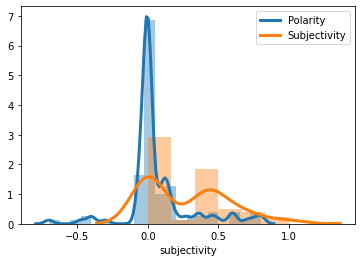

In [35]:
# Sacamos el histograma,la densidaddensidad de la polaridad y la subjetividad

import seaborn as sns
sns.distplot( df['polarity'], bins=20, kde_kws={"lw": 3,"label": "Polarity"})
sns.distplot( df['subjectivity'], kde_kws={"lw": 3, "label": "Subjectivity"})